# Наивный Байес

Импортирую нужные библиотеки и загружаю датасет.

In [56]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

messages = pandas.read_csv('SMSSpamCollection', sep='\t', names=["label", "message"])

In [10]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [47]:
print(messages.groupby('label').describe())

                                                        message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


Как показывает группировка данных по классам, датасет не сбалансированный, так как спама сильно больше, чем не спама. Если всем новым наблюдениям присваивать класс ham, то точность будет достаточно высокой, но с точки зрения задачи классификации спами это плохое решение, так как такой классификатор вообще не будет отсеивать спам. 

**Балансирую данные**

In [48]:
spam = messages[messages['label'] == 'spam']

In [49]:
spam.head()

,label,message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [62]:
ham = messages[messages['label'] == 'ham']

In [28]:
print(len(ham))

4825


In [61]:
less_ham = ham.sample(n=len(spam))
print(len(less_ham))

747


In [351]:
balanced = pandas.concat([less_ham, spam])
print(balanced.groupby('label').describe())

                                                        message
label                                                          
ham   count                                                 747
      unique                                                732
      top                                Sorry, I'll call later
      freq                                                    4
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


Теперь соотношение 1:1

## Наивный Байес, фичи – слова

Обучаю модель с дефолтными характеристиками: убираем знаки препинания, не лемматизируем.

In [187]:
bow = CountVectorizer()
bow.fit_transform(balanced['message'])
bowed_messages = bow.transform(balanced['message'])

In [188]:
# 10 рандомных токенов
list(bow.vocabulary_.keys())[:10]

['gettin',
 'fyi',
 'breathe1',
 'text',
 'hoody',
 'pages',
 'panther',
 '08712101358',
 'chatlines',
 'smiling']

Как видим, по дефолту ничего не лемматизируется.

In [189]:
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [191]:
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.963 0.011


Теперь попробуем оставить знаки препинания, используя токенизатор word_tokenize. Он оставляет знаки препинания.

In [209]:
def tokenize_leave_punct(text): return word_tokenize(text.lower())

bow = CountVectorizer(tokenizer=tokenize_leave_punct)
bow.fit_transform(balanced['message'])
bowed_messages = bow.transform(balanced['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.954 0.015


Со знаками препинания получилось хуже. Правда, эксперимент был не совсем чистым, потому что токенизаторы вообще разные.

Теперь попробуем лемматизировать.

In [194]:
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

def lemmatize(word):
    noun = lmtzr.lemmatize(word)
    verb = lmtzr.lemmatize(word, 'v')
    if verb != word:
        return verb
    return noun

Attention!
Кусочек кода в клетке выше позаимствован у Тани Гавриловой после того, как мы с ней обсудили следующую проблему (обнаруженную ей). У лемматизатора ворднетлемматайзера nltk есть аргумент, отвечающий за часть речи. По дефолту он считает, что ему подали существительное, и лемматизирует его как существительное. Соответственно, результатом для слова leaves будет leaf, а для going так и останется going.

In [202]:
lmtzr.lemmatize('leaves')

'leaf'

In [203]:
lmtzr.lemmatize('going')

'going'

Естественно, если подать ему аргумент 'v', всё будет иначе.

In [200]:
lmtzr.lemmatize('leaves', 'v')

'leave'

In [201]:
lmtzr.lemmatize('going', 'v')

'go'

Сообветственно, чтобы лемматизация была адекватной, нужно сначала использовать POS тэггер, его выдачу преобразовывать и подавать на вход лемматизатору. У nltk есть pos_tag, но те тэги, который она выдаёт, отличаются от тэгов, которые принимает на вход лемматизатор, причём их много и они разные. Соответственно, можно со всем этим долго возиться и бомбить на тему того, почему нельзя было разу сделать нормальный лемматизатор. А можно воспользоваться тем костылём, что если лемматизация словоформы как глагола даёт какой-то результат, отличный от самой словоформы, то, видимо, это был глагол (или существительное во множественном числе, которое лемматизируется так же). Проблему с leaves это всё же решит плохо, но leaves больше похоже на единичный случай.

In [207]:
def tokenize_lemmatize(text):
    text = word_tokenize(text.lower())
    return [lemmatize(word) for word in text]

In [208]:
bow = CountVectorizer(tokenizer=tokenize_lemmatize)
bow.fit_transform(balanced['message'])
bowed_messages = bow.transform(balanced['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.954 0.012


Результаты практически не изменились.

In [218]:
def tokenize_lemmatize(text):
    text = word_tokenize(text.lower())
    return [lemmatize(word) for word in text if word not in '!?,.":;']

bow = CountVectorizer(tokenizer=tokenize_lemmatize)
bow.fit_transform(balanced['message'])
bowed_messages = bow.transform(balanced['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.955 0.014


Без знаков препинания чуууть-чуть получше.

Теперь попробую убирать стоп-слова.

In [221]:
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

def tokenize_lemmatize(text):
    text = word_tokenize(text.lower())
    text = [lemmatize(word) for word in text if word not in '!?,.":;']
    return [word for word in text if word not in STOPWORDS]

bow = CountVectorizer(tokenizer=tokenize_lemmatize)
bow.fit_transform(balanced['message'])
bowed_messages = bow.transform(balanced['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.944 0.014


Значительно хуже. :/


В общем, кажется, лучше не лемматизировать и убирать знаки препинания (или просто дефолтный токенизатор CountVectorizer работает настолько лучше). А что если использовать его и убирать стоп-слова?

In [281]:
bow = CountVectorizer(stop_words=STOPWORDS)
bow.fit_transform(balanced['message'])
bowed_messages = bow.transform(balanced['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.95 0.018


Хм, нет, убирать стоп-слова было явно плохой идеей. Хотя встроенный токенизатор и правда работает лучше.

Теперь попробую дефолтные настройки и ограничивать df.

Сверху:

In [232]:
bow = CountVectorizer(max_df=0.3)
bow.fit_transform(balanced['message'])
bowed_messages = bow.transform(balanced['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.964 0.011


Потрясающе, стало лучше, чем дефолт! (Но не сильно).
Я попробовала несколько разных порогов, лучше всего работает в районе 0.3.

Снизу:

In [295]:
bow = CountVectorizer(min_df=2)
bow.fit_transform(balanced['message'])
bowed_messages = bow.transform(balanced['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.965 0.01


Лучше всего работает порог 2.

Кажется, это вообще лучший результат. А вот полный classification_report для него.

In [291]:
from sklearn.model_selection import cross_val_predict

predicted = cross_val_predict(naive_model, bowed_messages, balanced['label'], cv=10)
print(classification_report(balanced['label'], predicted))

             precision    recall  f1-score   support

        ham       0.95      0.98      0.97       747
       spam       0.98      0.95      0.96       747

avg / total       0.96      0.96      0.96      1494



И сверху, и снизу:

In [252]:
bow = CountVectorizer(min_df=2, max_df=0.3)
bow.fit_transform(balanced['message'])
bowed_messages = bow.transform(balanced['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.963 0.01


А вот так хуже о_О.

Теперь попробую TfIdfVectorizer с дефолтными настройками.

In [268]:
count_vect = CountVectorizer()
counts = count_vect.fit_transform(balanced['message'])
tfidf_transformer = TfidfTransformer().fit(counts)
tfidf = tfidf_transformer.transform(counts)
naive_model = MultinomialNB()
naive_model.fit(tfidf, balanced['label'])
cv_results = cross_val_score(naive_model, tfidf, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.964 0.009


Кажется, очень даже неплохие результаты. А что если добавить чего-нибудь успешного из прошлых шагов?

In [273]:
count_vect = CountVectorizer(min_df=2)
counts = count_vect.fit_transform(balanced['message'])
tfidf_transformer = TfidfTransformer().fit(counts)
tfidf = tfidf_transformer.transform(counts)
naive_model = MultinomialNB()
naive_model.fit(tfidf, balanced['label'])
cv_results = cross_val_score(naive_model, tfidf, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.957 0.015


Не очень-то. Ну ладно.

**В общем, лучше всего получилось, кажется, при дефолтных настройках CountVectorizer с нижним ограничением на количество вхождений 2 и с применением TfidfTransformer.**

## Деревья решений и рандомный лес.

In [307]:
from sklearn.tree import DecisionTreeClassifier

bow = CountVectorizer()
bow.fit_transform(balanced['message'])
bowed_messages = bow.transform(balanced['message'])

tree = DecisionTreeClassifier(min_samples_split=5)
tree.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(tree, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.922 0.021


In [292]:
predicted = cross_val_predict(tree, bowed_messages, balanced['label'], cv=10)
print(classification_report(balanced['label'], predicted))

             precision    recall  f1-score   support

        ham       0.91      0.94      0.92       747
       spam       0.94      0.91      0.92       747

avg / total       0.92      0.92      0.92      1494



Дерево решений работает значительно хуже.

In [309]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(round(cv_results.mean(), 3), round(cv_results.std(), 3))

0.939 0.021


In [310]:
predicted = cross_val_predict(model, bowed_messages, balanced['label'], cv=10)
print(classification_report(balanced['label'], predicted))

             precision    recall  f1-score   support

        ham       0.89      0.98      0.94       747
       spam       0.98      0.88      0.93       747

avg / total       0.94      0.93      0.93      1494



Рандомный лес лучше, чем дерево, но хуже, чем наивный Байес.

Теперь построим для всего этого learning curve.

In [305]:
# скопипащено из туториала склёрна
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

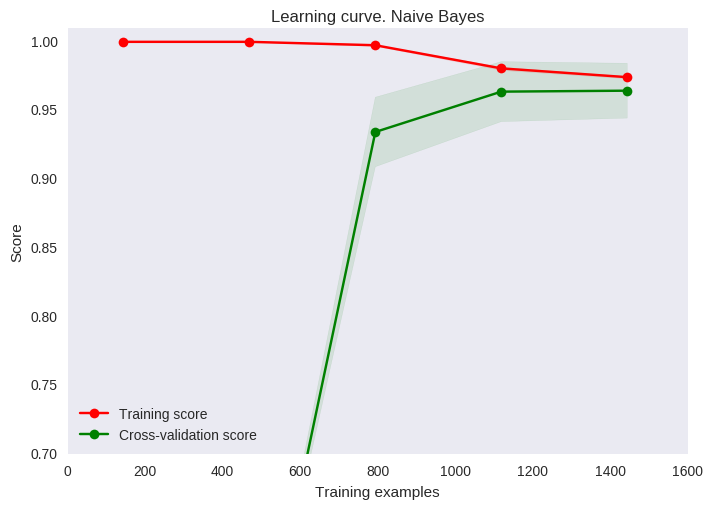

In [306]:
# это та модель, которая даёт лучший результат (classification_report для неё там выше)
plot_learning_curve(naive_model, "Learning curve. Naive Bayes", bowed_messages, 
                    balanced['label'], ylim=(0.7, 1.01), cv=30, n_jobs=4)
plt.show()

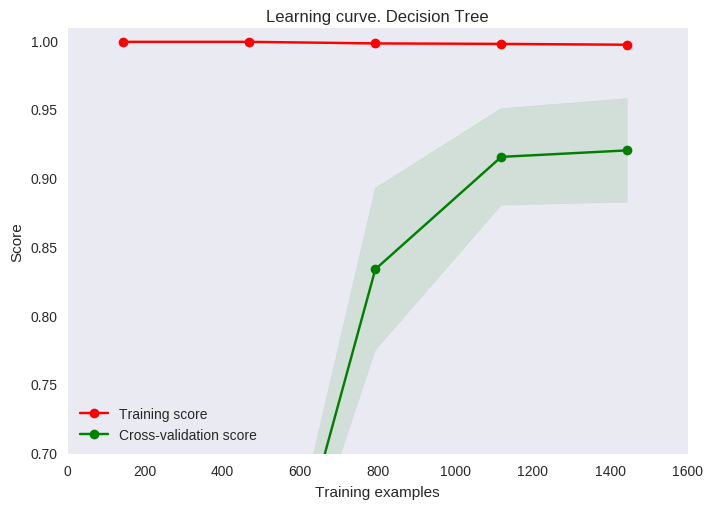

In [308]:
plot_learning_curve(tree, "Learning curve. Decision Tree", bowed_messages, 
                    balanced['label'], ylim=(0.7, 1.01), cv=30, n_jobs=4)
plt.show()

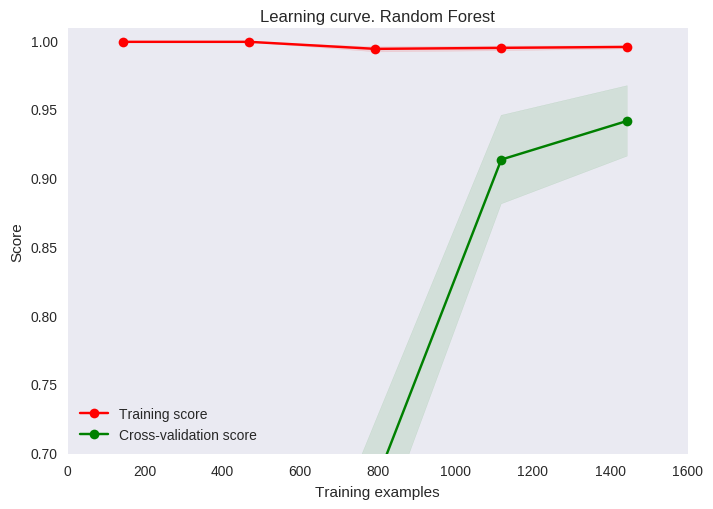

In [311]:
plot_learning_curve(model, "Learning curve. Random Forest", bowed_messages, 
                    balanced['label'], ylim=(0.7, 1.01), cv=30, n_jobs=4)
plt.show()

Интерпрпетация: для дерева решений и рандомного леса данных слишком мало.

## Наивный Байес с другими фичами.

Делаю фичами длину сообщения словах. Потому что ~~могу~~ наверное что-то из этого длиннее.

In [354]:
balanced['word_length'] = balanced['message'].map(lambda text: len(text.split()))

Делаю фичами количество капсовых букв в сообщении. Просмотр данных глазами показывает, что в спаме ОЧЕНЬ МНОГО КАПСА.

In [353]:
import string
def count_caps(text):
    return len([sym for sym in text if sym in string.ascii_uppercase])
balanced['num_of_caps'] = balanced['message'].map(count_caps)
balanced.head()

,label,message,word_length,num_of_caps
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...,25,3
220,ham,Yeah you should. I think you can use your gt a...,35,4
1664,ham,S but mostly not like that.,6,1
332,ham,Maybe i could get book out tomo then return it...,14,2
4343,ham,Ha! I wouldn't say that I just didn't read any...,27,4


In [355]:
balanced.tail()

,label,message,word_length,num_of_caps
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,16,17
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,33,104
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,28,20
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,28,14
5567,spam,This is the 2nd time we have tried 2 contact u...,30,9


In [363]:
sms_y = balanced['label']
sms_x = balanced.loc[:, ('word_length', 'num_of_caps')]
train_x, test_x, train_y, test_y = train_test_split(sms_x, sms_y, test_size=0.2)

In [364]:
naive_model = MultinomialNB()
naive_model.fit(train_x, train_y)
predict_y = naive_model.predict(test_x)
print(classification_report(test_y, predict_y))

             precision    recall  f1-score   support

        ham       0.69      0.92      0.79       140
       spam       0.90      0.64      0.75       159

avg / total       0.80      0.77      0.77       299



С наивным Байесом получилось очень плохо.

In [365]:
tree = DecisionTreeClassifier()
tree.fit(train_x, train_y)
predict_y = tree.predict(test_x)
print(classification_report(test_y, predict_y))

             precision    recall  f1-score   support

        ham       0.85      0.89      0.87       140
       spam       0.90      0.86      0.88       159

avg / total       0.88      0.88      0.88       299



С деревом внезапно гораздо лучше.

In [366]:
forest = RandomForestClassifier()
forest.fit(train_x, train_y)
predict_y = forest.predict(test_x)
print(classification_report(test_y, predict_y))

             precision    recall  f1-score   support

        ham       0.88      0.89      0.89       140
       spam       0.90      0.89      0.90       159

avg / total       0.89      0.89      0.89       299



C рандомным лесом ещё чуть-чуть получше.

In [371]:
# А если добавить ещё одну фичу, пока есть время?
def count_punct(text):
    return len([sym for sym in text if sym in '!?'])
balanced['num_of_punct'] = balanced['message'].map(count_punct)
balanced.tail()

,label,message,word_length,num_of_caps,num_of_punct
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,16,17,2
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,33,104,0
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,28,20,2
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,28,14,0
5567,spam,This is the 2nd time we have tried 2 contact u...,30,9,1


In [372]:
sms_y = balanced['label']
sms_x = balanced.loc[:, ('word_length', 'num_of_caps', 'num_of_punct')]
train_x, test_x, train_y, test_y = train_test_split(sms_x, sms_y, test_size=0.2)

tree = DecisionTreeClassifier()
tree.fit(train_x, train_y)
predict_y = tree.predict(test_x)
print(classification_report(test_y, predict_y))

             precision    recall  f1-score   support

        ham       0.85      0.81      0.83       157
       spam       0.80      0.85      0.82       142

avg / total       0.83      0.83      0.83       299



Стало похуже... ну ладно.